In [1]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import scanpy as sc
from scipy import sparse

import sys
sys.path.append('/home/cl2292/project/')
# from scnd.scripts import data as scnddata
# from scnd.scripts import utils as scndutils


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

In [2]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/results/'
sc.settings.figdir = pfp

# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='220328_WT_sampling.h5ad' # for full, can maybe get away with ~300G
    %memit wt1 = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))


if True :
    start = time.time()
    backed=None # None if not
    fname='220328_SCA1_sampling.h5ad' # for full, can maybe get away with ~300G
    %memit mut1 = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))

peak memory: 22181.59 MiB, increment: 21986.96 MiB
loaded @220804.10:16:36
took 23.55-s to load data
peak memory: 44297.56 MiB, increment: 22115.95 MiB
loaded @220804.10:17:01
took 25.18-s to load data


In [3]:
# aesthetics
cmap_wt = {v:sns.cubehelix_palette(5, start=0.5, rot=-0.75)[i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}
cmap_mut = {v:sns.cubehelix_palette(5)[i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

In [ ]:
for ctype in ['GC']:
    wt = wt1[(wt1.obs['sub4']==ctype) & (wt1.obs['genotype']=='WT')]
    mut = mut1[(mut1.obs['sub4']==ctype) & (mut1.obs['genotype']=='SCA1')]

    sc.pp.pca(wt)
    sc.pp.neighbors(wt, n_pcs=50)
    sc.pp.pca(mut)
    sc.pp.neighbors(mut, n_pcs=50)

    # MELD
    G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    
    # phate
    sc.tl.leiden(wt, resolution=3.0)
    sc.tl.umap(wt)
    phate_op = phate.PHATE(knn_dist='precomputed',
                           gamma=1,
                           decay=40,
                           n_jobs=-1,
                           t='auto',
                           random_state=42)
    wt.obsm['X_phate'] = phate_op.fit_transform(G.K)
    
    # meld
    wt.obs['res_t']=-1
    wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
    wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
    wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
    wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
    wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
    
    # MELD
    G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
    G.knn_max = None
    
    # phate
    sc.tl.leiden(mut, resolution=3.0)
    sc.tl.umap(mut)
    phate_op = phate.PHATE(knn_dist='precomputed',
                           gamma=1,
                           decay=40,
                           n_jobs=-1,
                           t='auto',
                           random_state=42)
    mut.obsm['X_phate'] = phate_op.fit_transform(G.K)
    
    # meld
    mut.obs['res_t']=-1
    mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
    mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
    mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
    mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
    mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])


    # 1d phate
    wt_phate1d = phate.PHATE(knn=15, gamma=0, n_components=1).fit_transform(wt.X)
    mut_phate1d = phate.PHATE(knn=15, gamma=0, n_components=1).fit_transform(mut.X)

    # plots 
    fig, ax = plt.subplots(3,2, figsize=(9,11))
    sns.scatterplot(
        x=wt.obsm['X_phate'][:,0],
        y=wt.obsm['X_phate'][:,1],
        hue=wt.obs['timepoint'].to_list(),
        palette=cmap_wt,
        ax=ax[1,0],
        linewidth=0,
        s=6,
        rasterized=True)
    ax[1,0].set_xlabel('PHATE1')
    ax[1,0].set_ylabel('PHATE2')
    ax[1,0].set_xticks([])
    ax[1,0].set_yticks([])
    
    p = ax[1,1].scatter(wt.obsm['X_phate'][:,0],
                        wt.obsm['X_phate'][:,1],
                        c=wt.obs['ees_t'],
                        cmap='magma', s=6,
                        rasterized=True)
    fig.colorbar(p, pad=0, ax=ax[1,1])
    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])
    ax[1,1].set_xlabel('PHATE1')
    ax[1,1].set_ylabel('PHATE2')
    
    sns.scatterplot(
        x=mut.obsm['X_phate'][:,0],
        y=mut.obsm['X_phate'][:,1],
        hue=mut.obs['timepoint'].to_list(),
        palette=cmap_mut,
        ax=ax[2,0],
        linewidth=0,
        s=6,
        rasterized=True)
    ax[2,0].set_xlabel('PHATE1')
    ax[2,0].set_ylabel('PHATE2')
    ax[2,0].set_xticks([])
    ax[2,0].set_yticks([])
    
    p = ax[2,1].scatter(mut.obsm['X_phate'][:,0],
                        mut.obsm['X_phate'][:,1],
                        c=mut.obs['ees_t'],
                        cmap='magma', s=6, 
                        rasterized=True)
    fig.colorbar(p, pad=0, ax=ax[2,1])
    ax[2,1].set_xticks([])
    ax[2,1].set_yticks([])
    ax[2,1].set_xlabel('PHATE1')
    ax[2,1].set_ylabel('PHATE2')

    sns.scatterplot(
        x=wt.obs['ees_t'].to_list(),
        y=wt_phate1d.flatten(),
        hue=wt.obs['timepoint'].to_list(),
        palette=cmap_wt,
        ax=ax[0,0],
        linewidth=0,
        s=6, 
        rasterized=True)
    ax[0,0].set_xlabel('Pseudotime (MELD)')
    ax[0,0].set_ylabel('PHATE1')
    ax[0,0].set_title(ctype)
    if False:
        # plot smooth line
        z = lowess(phate_1d.flatten(), wt.obs['ees_t'].to_numpy())
        ax[1].plot(z[:,0], z[:,1], 'k-', lw=2)
        
    sns.scatterplot(
        x=mut.obs['ees_t'].to_list(),
        y=mut_phate1d.flatten(),
        hue=mut.obs['timepoint'].to_list(),
        palette=cmap_mut,
        ax=ax[0,1],
        linewidth=0,
        s=6, 
        rasterized=True)
    ax[0,1].set_xlabel('Pseudotime (MELD)')
    ax[0,1].set_ylabel('PHATE1')
    ax[0,1].set_title(ctype)
    if False:
        # plot smooth line
        z = lowess(phate_1d.flatten(), wt.obs['ees_t'].to_numpy())
        ax[1].plot(z[:,0], z[:,1], 'k-', lw=2)
    
    if True:
        fig.savefig(os.path.join(pfp, 'pseudotime_{}.pdf'.format(ctype)), bbox_inches='tight', dpi=600)
        
    del wt, mut
        
        

computing PCA
    with n_comps=50
    finished (0:01:27)
computing neighbors
    using 'X_pca' with n_pcs = 50


/gpfs/ysm/project/lim_janghoo/cl2292/conda_envs/sc_tutorial/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished (0:00:20)
computing PCA
    with n_comps=50
    finished (0:01:38)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:10)
running Leiden clustering
    finished (0:00:19)
computing UMAP
    finished (0:01:15)
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 78225 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.13 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 9.93 seconds.
    Calculating KMeans...


In [ ]:
for ctype in ['OPC','OL']: #'MLI1','MLI2','GoC','AS','BG','OPC','OL','MG','PER','END'
    wt = wt1[(wt1.obs['sub4']==ctype) & (wt1.obs['genotype']=='WT')]
    mut = mut1[(mut1.obs['sub4']==ctype) & (mut1.obs['genotype']=='SCA1')]

    sc.pp.pca(wt)
    sc.pp.neighbors(wt, n_pcs=50)
    sc.pp.pca(mut)
    sc.pp.neighbors(mut, n_pcs=50)

    # MELD
    G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    
    # phate
    sc.tl.leiden(wt, resolution=3.0)
    sc.tl.umap(wt)
    phate_op = phate.PHATE(knn_dist='precomputed',
                           gamma=1,
                           decay=40,
                           n_jobs=-1,
                           t='auto',
                           random_state=42)
    wt.obsm['X_phate'] = phate_op.fit_transform(G.K)
    
    # meld
    wt.obs['res_t']=-1
    wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
    wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
    wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
    wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
    wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
    
    # MELD
    G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
    G.knn_max = None
    
    # phate
    sc.tl.leiden(mut, resolution=3.0)
    sc.tl.umap(mut)
    phate_op = phate.PHATE(knn_dist='precomputed',
                           gamma=1,
                           decay=40,
                           n_jobs=-1,
                           t='auto',
                           random_state=42)
    mut.obsm['X_phate'] = phate_op.fit_transform(G.K)
    
    # meld
    mut.obs['res_t']=-1
    mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
    mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
    mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
    mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
    mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])


    # 1d phate
    wt_phate1d = phate.PHATE(knn=15, gamma=0, n_components=1).fit_transform(wt.X)
    mut_phate1d = phate.PHATE(knn=15, gamma=0, n_components=1).fit_transform(mut.X)

    # plots 
    fig, ax = plt.subplots(3,2, figsize=(9,11))
    sns.scatterplot(
        x=wt.obsm['X_phate'][:,0],
        y=wt.obsm['X_phate'][:,1],
        hue=wt.obs['timepoint'].to_list(),
        palette=cmap_wt,
        ax=ax[1,0],
        linewidth=0,
        s=6,
        rasterized=True)
    ax[1,0].set_xlabel('PHATE1')
    ax[1,0].set_ylabel('PHATE2')
    ax[1,0].set_xticks([])
    ax[1,0].set_yticks([])
    
    p = ax[1,1].scatter(wt.obsm['X_phate'][:,0],
                        wt.obsm['X_phate'][:,1],
                        c=wt.obs['ees_t'],
                        cmap='magma', s=6,
                        rasterized=True)
    fig.colorbar(p, pad=0, ax=ax[1,1])
    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])
    ax[1,1].set_xlabel('PHATE1')
    ax[1,1].set_ylabel('PHATE2')
    
    sns.scatterplot(
        x=mut.obsm['X_phate'][:,0],
        y=mut.obsm['X_phate'][:,1],
        hue=mut.obs['timepoint'].to_list(),
        palette=cmap_mut,
        ax=ax[2,0],
        linewidth=0,
        s=6,
        rasterized=True)
    ax[2,0].set_xlabel('PHATE1')
    ax[2,0].set_ylabel('PHATE2')
    ax[2,0].set_xticks([])
    ax[2,0].set_yticks([])
    
    p = ax[2,1].scatter(mut.obsm['X_phate'][:,0],
                        mut.obsm['X_phate'][:,1],
                        c=mut.obs['ees_t'],
                        cmap='magma', s=6, 
                        rasterized=True)
    fig.colorbar(p, pad=0, ax=ax[2,1])
    ax[2,1].set_xticks([])
    ax[2,1].set_yticks([])
    ax[2,1].set_xlabel('PHATE1')
    ax[2,1].set_ylabel('PHATE2')

    sns.scatterplot(
        x=wt.obs['ees_t'].to_list(),
        y=wt_phate1d.flatten(),
        hue=wt.obs['timepoint'].to_list(),
        palette=cmap_wt,
        ax=ax[0,0],
        linewidth=0,
        s=6, 
        rasterized=True)
    ax[0,0].set_xlabel('Pseudotime (MELD)')
    ax[0,0].set_ylabel('PHATE1')
    ax[0,0].set_title(ctype)
    if False:
        # plot smooth line
        z = lowess(phate_1d.flatten(), wt.obs['ees_t'].to_numpy())
        ax[1].plot(z[:,0], z[:,1], 'k-', lw=2)
        
    sns.scatterplot(
        x=mut.obs['ees_t'].to_list(),
        y=mut_phate1d.flatten(),
        hue=mut.obs['timepoint'].to_list(),
        palette=cmap_mut,
        ax=ax[0,1],
        linewidth=0,
        s=6, 
        rasterized=True)
    ax[0,1].set_xlabel('Pseudotime (MELD)')
    ax[0,1].set_ylabel('PHATE1')
    ax[0,1].set_title(ctype)
    if False:
        # plot smooth line
        z = lowess(phate_1d.flatten(), wt.obs['ees_t'].to_numpy())
        ax[1].plot(z[:,0], z[:,1], 'k-', lw=2)
    
    if True:
        fig.savefig(os.path.join(pfp, 'pseudotime_{}.pdf'.format(ctype)), bbox_inches='tight', dpi=600)
        
    del wt, mut
        
        

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:01)
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 317 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 0.05 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.01 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.09 seconds.
Calculated PHATE in 0.16 seconds.
running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:01)
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 269 observations.
  Calculating graph and diffusion opera

computing PCA
    with n_comps=50
    finished (0:01:30)
computing neighbors
    using 'X_pca' with n_pcs = 50


/gpfs/ysm/project/lim_janghoo/cl2292/conda_envs/sc_tutorial/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished (0:00:22)
computing PCA
    with n_comps=50
    finished (0:01:36)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:10)


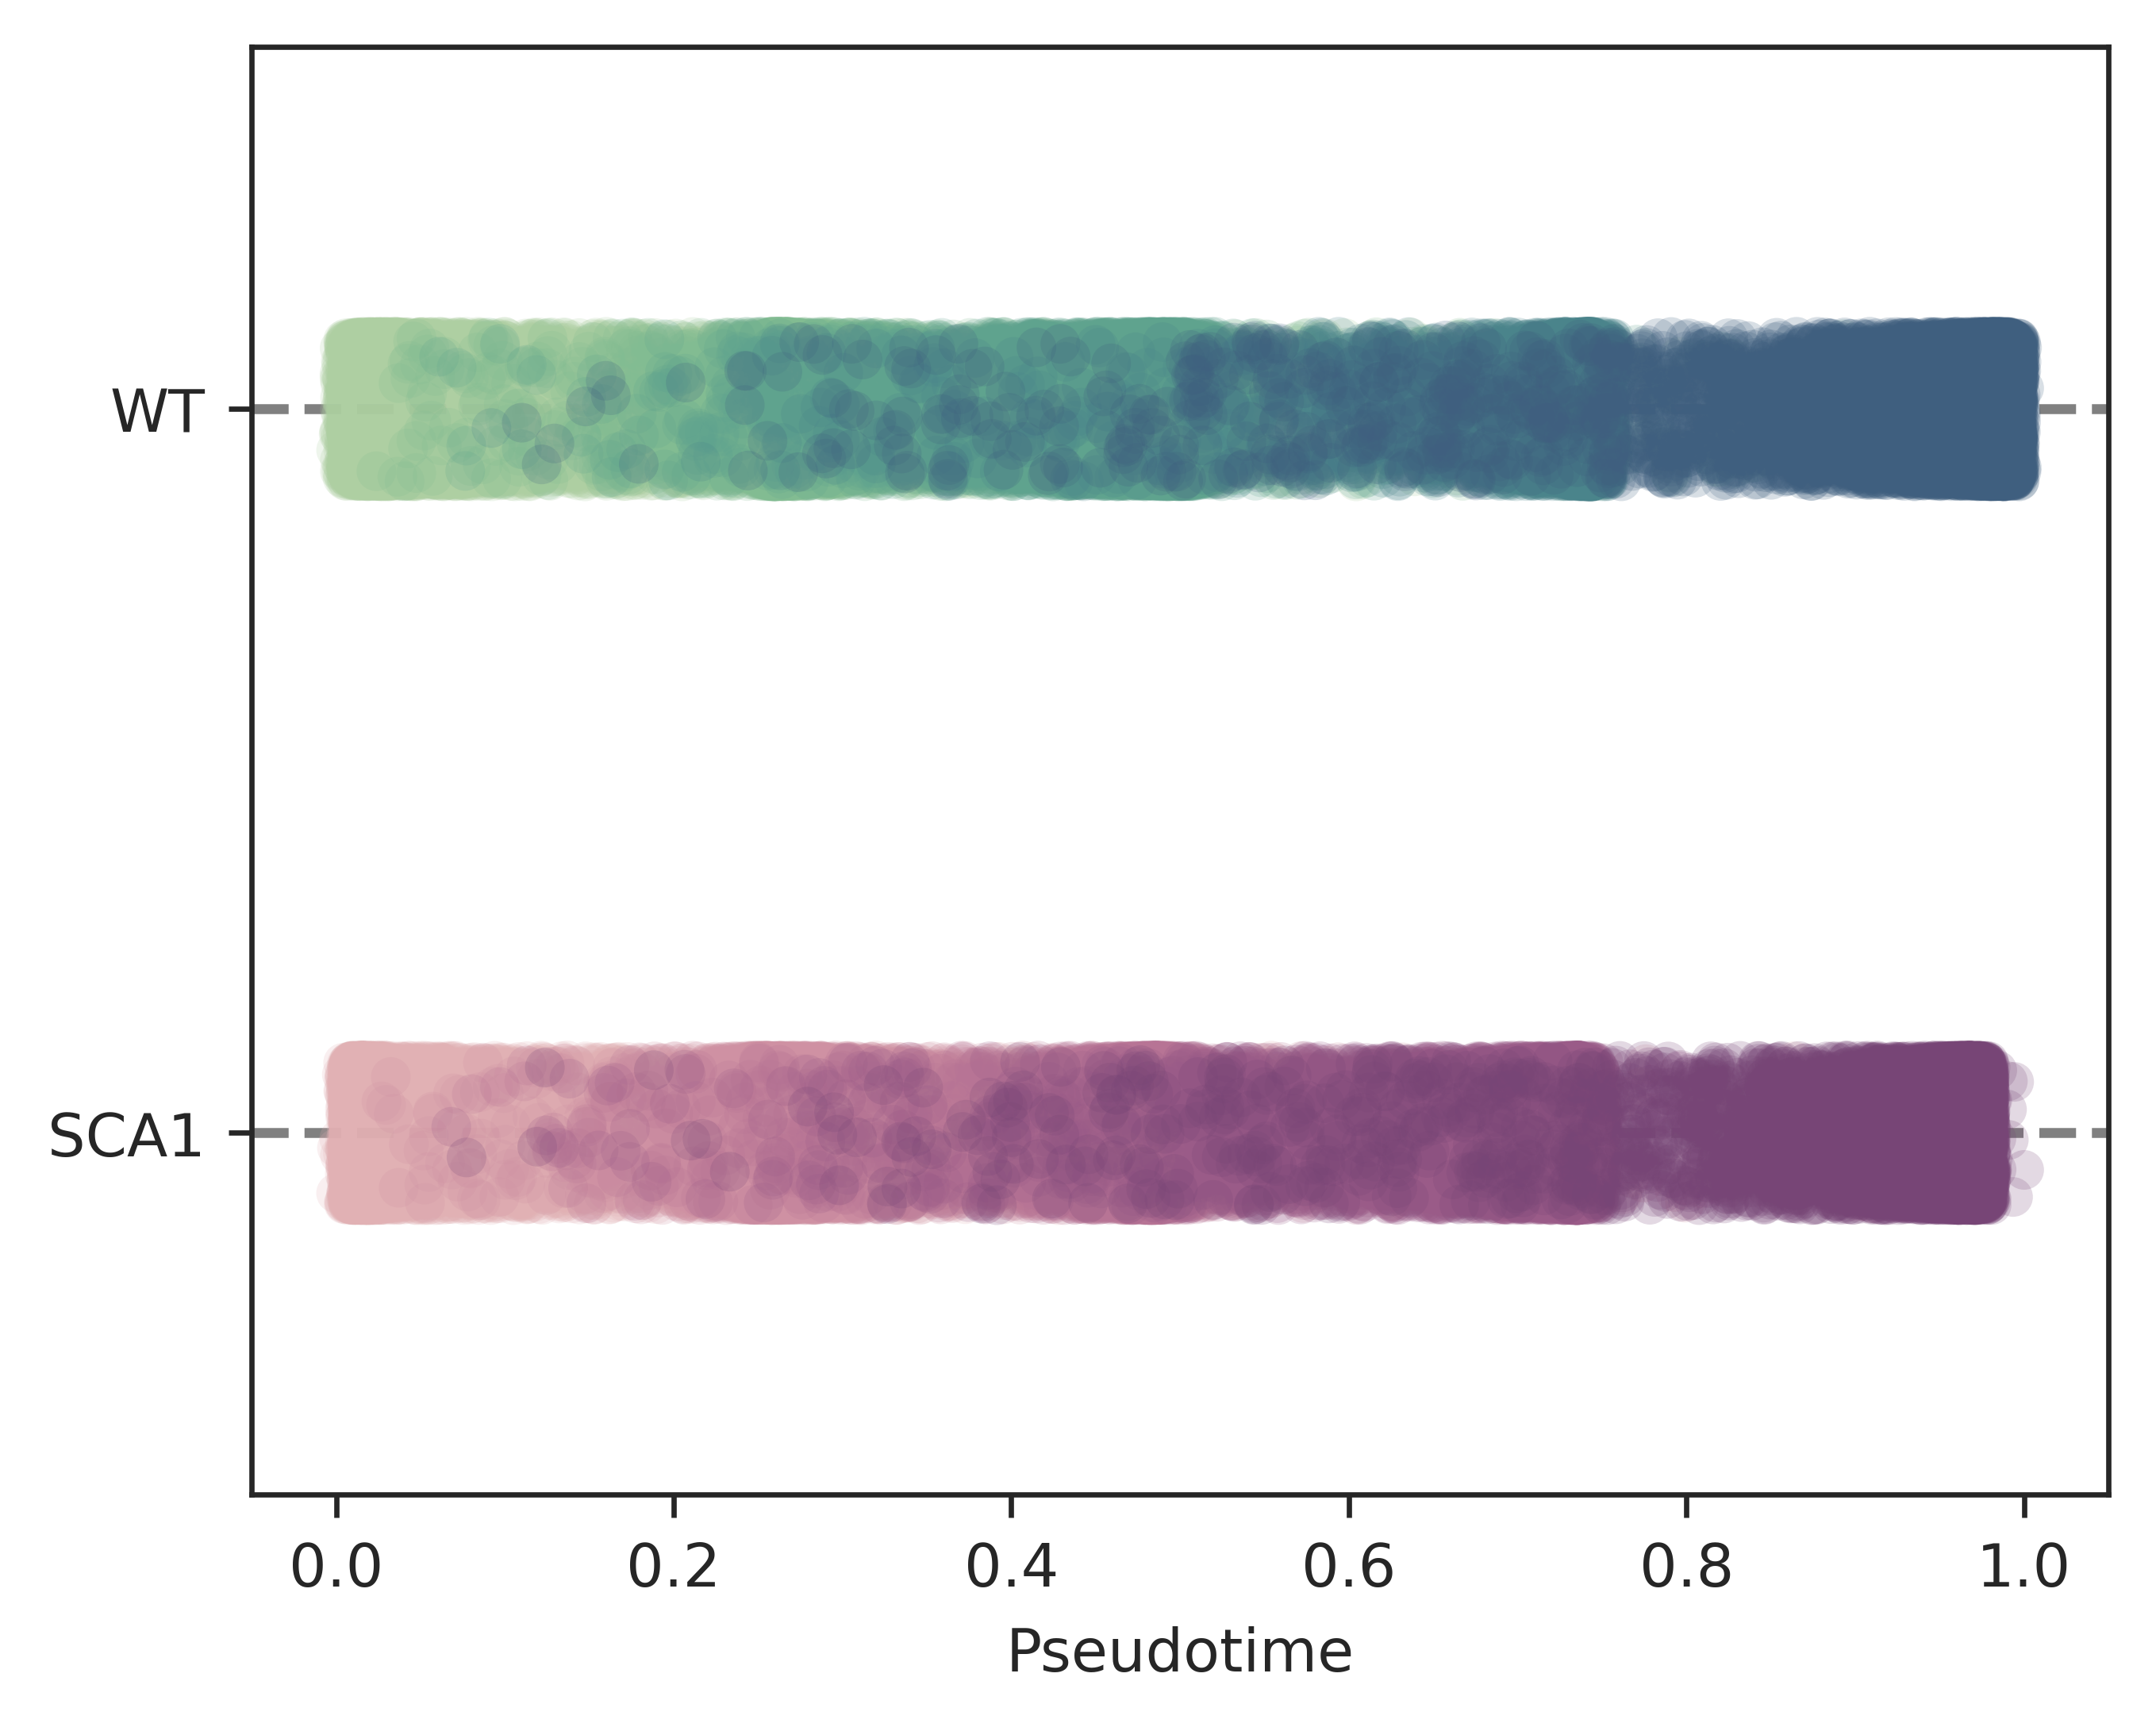

In [3]:
#jitter plot

# aesthetics
cmap_wt = {v:sns.cubehelix_palette(8, start=0.5, rot=-0.75)[i+1] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}
cmap_mut = {v:sns.cubehelix_palette(8)[i+1] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_gt = {}
for k in cmap_wt.keys():
    cmap_gt['WT_{}'.format(k)] = cmap_wt[k]
    cmap_gt['SCA1_{}'.format(k)] = cmap_mut[k]
for ctype in ['GC']:#[i for i in adata.obs['ctype'].unique() if 'Granule' not in i]:
    wt = wt1[(wt1.obs['sub4']==ctype) & (wt1.obs['genotype']=='WT')]
    mut = mut1[(mut1.obs['sub4']==ctype) & (mut1.obs['genotype']=='SCA1')]

    sc.pp.pca(wt)
    sc.pp.neighbors(wt, n_pcs=50)
    sc.pp.pca(mut)
    sc.pp.neighbors(mut, n_pcs=50)

    # MELD
    G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    wt.obs['res_t']=-1
    wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
    wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
    wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
    wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
    wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
    wt.obs['ees_t'] = (wt.obs['ees_t'] - wt.obs['ees_t'].min()) / (wt.obs['ees_t'].max() - wt.obs['ees_t'].min())
    
    G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
    G.knn_max = None
    mut.obs['res_t']=-1
    mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
    mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
    mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
    mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
    mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])
    mut.obs['ees_t'] = (mut.obs['ees_t'] - mut.obs['ees_t'].min()) / (mut.obs['ees_t'].max() - mut.obs['ees_t'].min())

    X = pd.DataFrame({'timepoint': wt.obs['timepoint'].to_list(),
                      'genotype': wt.obs['genotype'].to_list(),
                      'Pseudotime': wt.obs['ees_t'].to_list()})
    dt = pd.DataFrame({'timepoint': mut.obs['timepoint'].to_list(),
                      'genotype': mut.obs['genotype'].to_list(),
                      'Pseudotime': mut.obs['ees_t'].to_list()})
    
    X = X.append(dt, ignore_index=True)
    del dt
    
    X['gt'] = X['genotype'] + '_' + X['timepoint']
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    sns.stripplot(
        x='Pseudotime',
        y='genotype',
        hue='gt',
        data=X,
        order=None,
        hue_order=None,
        jitter=True,
        dodge=False,
        orient=None,
        color=None,
        palette=cmap_gt,
        size=6,
        alpha=0.2,
        edgecolor='gray',
        linewidth=0,
        ax=ax,
        rasterized=True
    )
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot([xlim[0], xlim[1]], ['WT', 'WT'], color='gray', linestyle='dashed')
    ax.plot([xlim[0], xlim[1]], ['SCA1', 'SCA1'], color='gray', linestyle='dashed')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend().set_visible(False)
    ax.set_ylabel('')
    
    if True:
        fig.savefig(os.path.join(pfp, 'pseudotime1d_{}.pdf'.format(ctype)), bbox_inches='tight', dpi=600)
        
                